#### ▶ **Candidate Numbers: 15, 18, 17, 33, 42**

# **Jupyter Notebook 1:	Master U-Net Workflow**

---











🌿  We decided that the Jupyter notebook will contain a total of 6 sections, each dedicated to a separate experiment for easier navigation, as outlined below:


| Total number of Notebook: 6                         | Content                                                                                   |
|------------------------------------|-------------------------------------------------------------------------------------------|
|**Jupyter Notebook 1: Master U-Net Workflow**              | **Data preparation, U-Net implementation, training, and evaluation**                           |
|Jupyter Notebook 2: Impact of Image Resolution      | Experiment with 3 different image resolutions and track performance (64x64, 128x128 and 256x256)                        |
|Jupyter Notebook 3: Impact of Data Augmentation     | Experiment with data augmentation techniques (3 augmentation with vs. without augmentation)               |
|Jupyter Notebook 4: Impact of Training Data Size    | Experiment with 3 different training data sizes (20%, 50% and 100%)                      |
|Jupyter Notebook 5: Impact of Optimizer             | Experiment with 3 different optimizers (Adam, SGD, RMSprop)                                  |
|Jupyter Notebook 6: Impact of Activation Function   | Experiment with 3 different activation functions (ReLU, Leaky Tanh with Sigmoid)           |


🌿 **Note :**This Jupyter Notebook imports the train.txt, test.txt, images.tar.gz, and mask.tar.gz files by uploading them directly to the notebook. Once the files are uploaded, you can continue by running the following code to proceed with the experiment.

# **Install Required Libaries:**

---



In [ ]:
!pip install torch torchvision
!pip install torchsummary
!pip install wandb

In [ ]:
import os
from PIL import Image
import albumentations as A
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import random
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from albumentations.pytorch import ToTensorV2
import torch
import wandb
from torch.utils.data import Dataset
from albumentations import Compose
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim.lr_scheduler as lr_scheduler

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# **Check if CUDA device exists, use that. If not default to CPU:**

---



In [ ]:
# If CUDA device exist, use that. If not default to CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


#🍀 **Wandb Installation**

---



In [ ]:
!pip install wandb
!wandb login
import wandb

wandb: Currently logged in as: kandidat18 (kandidat18-kristiania-university-college). Use `wandb login --relogin` to force relogin




---


# 🍀**Data Pipeline**


---





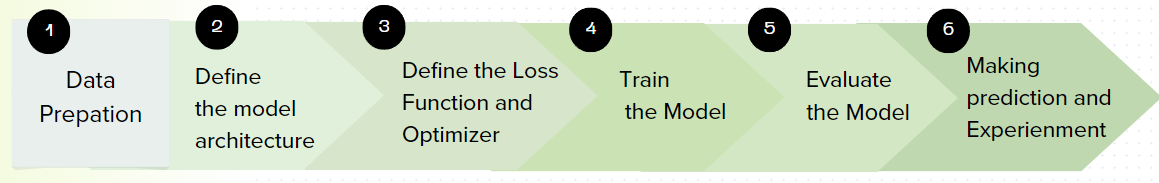

Data Pipeline for Image Segmentation

**1. Prepare the Dataset**
  - Download the dataset from Kvasir-Instrument Organize data into training and test sets, ensuring the split is respected as provided in the dataset.

**2. Define the Model Architecture**
  - Define and implement the model architecture (e.g., U-Net) tailored for medical image segmentation.

**3. Define the Loss Function and Optimizer**
Initialize the model.
  - Set up an optimizer (e.g., Adam) and a loss function (e.g., Binary Cross Entropy) for binary segmentation.

**4. Train the Model**
  - Train the model on the training set.
Use the optimizer and loss function to iteratively update the model’s weights over several epochs.

**5. Evaluate the Model**
  - **Metrics:** Evaluate the model on the test set using metrics such as accuracy, precision, recall, IoU, and Dice Coefficient (DSC) to assess its performance.

  - **Segmentation Mask vs. Ground Truth:**
Visualize segmentation masks generated by the model compared with ground truth masks to better understand performance.

  - **Visualization:**
Utilize tools like Weights and Biases (WandB) for real-time performance tracking and visualization of metrics.

**6. Make Predictions and Experiment**

  Use the trained model to make predictions on new or unseen data.Experiment with variations to analyze their impact:
  - **Image Resolution:** Assess the effect of different resolutions on segmentation performance.
  - **Data Augmentation**: Investigate the role of augmentation techniques in improving model generalization.
  - **Training Data Size:** Evaluate how varying data sizes affect model accuracy and robustness.
  - **Optimization Methods:** Explore alternative optimizers to determine optimal training strategies.
  - **Activation Functions:** Test different activation functions to understand their impact on predictions.




---

# **1. Prepare the Dataset:**

---



## **1.1) Extract images and masks tar.gz files :**




▶ **Extract images and masks tar.gz files**

In [ ]:
with tarfile.open('/content/images.tar.gz', 'r:gz') as tar:
    tar.extractall('/content/images')
with tarfile.open('/content/masks.tar.gz', 'r:gz') as tar:
    tar.extractall('/content/masks')


▶ **Get the list of files in each directory and print their counts**

In [ ]:
images_dir = '/content/images/images'
masks_dir = '/content/masks/masks'

images_list = os.listdir(images_dir)
masks_list = os.listdir(masks_dir)

print(f"Number of images: {len(images_list)}")
print(f"Number of masks: {len(masks_list)}")
print(f".............................")
print(f"Images directories contents: {images_list[:10]}")
print(f"Masks directories contents: {masks_list[:10]}")

Number of images: 590
Number of masks: 590
.............................
Images directories contents: ['ckcuhqpeh001k3b5yg9ebvymx.jpg', 'ckcudd247000m3b5yjxgxd6vp.jpg', 'ckd03rjy4001q3b5y7kbvpqhm.jpg', 'ckcuhathy000y3b5yztf7bt9k.jpg', 'ckd04mx29000a3b5yxzr181jz.jpg', 'ckd4jcl8s00123b5yifl4o1dp.jpg', 'ckcx9ub1g00263b5ypitagqy9.jpg', 'ckd498dpe000c3b5y7ma9aibh.jpg', 'ckcud80aw000f3b5yjerqwsbq.jpg', 'ckcvwqk1z001d3b5y3q8bouy2.jpg']
Masks directories contents: ['ckd09bezs000c3b5yy33w0pw6.png', 'ckcua4qo3000w3b5yz2oxtkud.png', 'ckd034o6w000v3b5yq5tp0328.png', 'ckcui0yhw00033b5yqa3jsh9t.png', 'ckd092yf800013b5yhq7orv0b.png', 'ckd4il4jl00093b5y9rlfydho.png', 'ckcx9selb00233b5ya9d409ni.png', 'ckcuau0r900023b5y0s8h6sqf.png', 'ckd4bgbws000k3b5ytvwc86ut.png', 'ckd4h7fq300153b5yhdzs5yar.png']


▶ **Check if image and mask are in the binary range (0,1)**

In [ ]:
images_out_of_range_count = 0
masks_out_of_range_count = 0

# Check if all images are between 0 and 1
for i in images_list:
    image_path = os.path.join(images_dir, i)
    image = np.array(Image.open(image_path).convert("RGB")) / 255.0  # Normalize image to [0,1]

    if not np.all((image >= 0) & (image <= 1)):
        images_out_of_range_count += 1

# Check if all masks are binary (0,1)
for i in masks_list:
    mask_path = os.path.join(masks_dir, i)
    mask = np.array(Image.open(mask_path))

    if not np.all((mask == 0) | (mask == 1)):
        masks_out_of_range_count += 1

# Summary
if images_out_of_range_count == 0:
    print("All training images are within the range [0, 1].")
else:
    print(f"{images_out_of_range_count} training images have values outside the range [0, 1].")

if masks_out_of_range_count == 0:
    print("All training masks are binary (0 or 1).")
else:
    print(f"{masks_out_of_range_count} training masks have values outside the binary range [0, 1].")

All training images are within the range [0, 1].
590 training masks have values outside the binary range [0, 1].


▶ The summary results show that the masks have binary values outside the range [0, 1]. We have two possible options to address this:

1. Re-binarize masks with values outside [0, 1].
2. Use `transforms.ToTensor()` in the mask transformation, which will automatically scale the binary values from [0, 255] to [0, 1], making them suitable for most segmentation models.

We decided to use option 2 because all masks are already binary with values strictly at 0 and 255. Applying `ToTensor()` will correctly scale these values to [0, 1] without needing any additional processing.


▶ **Plot to see the distribution of both image and mask**

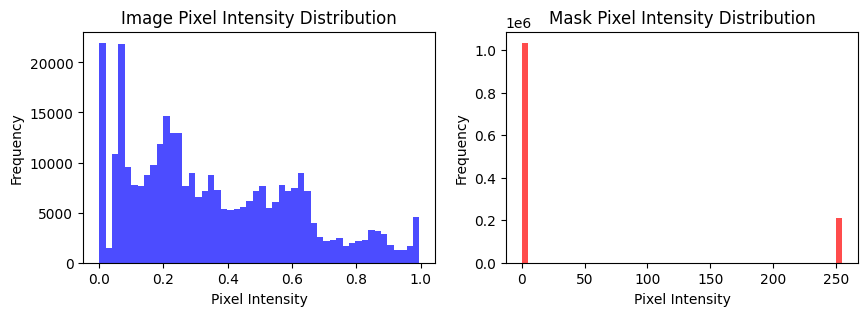

In [ ]:
import matplotlib.pyplot as plt

def plot_histogram(image_name, mask_name):
    image_path = os.path.join(images_dir, image_name)
    mask_path = os.path.join(masks_dir, mask_name)

    # Load image and mask
    image = np.array(Image.open(image_path).convert("L")) / 255.0
    mask = np.array(Image.open(mask_path))
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    # Image histogram
    axes[0].hist(image.ravel(), bins=50, color='blue', alpha=0.7)
    axes[0].set_title("Image Pixel Intensity Distribution")
    axes[0].set_xlabel("Pixel Intensity")
    axes[0].set_ylabel("Frequency")

    # Mask histogram
    axes[1].hist(mask.ravel(), bins=50, color='red', alpha=0.7)
    axes[1].set_title("Mask Pixel Intensity Distribution")
    axes[1].set_xlabel("Pixel Intensity")
    axes[1].set_ylabel("Frequency")
    plt.show()

plot_histogram(images_list[0], masks_list[0])


▶ **Find matchine images mask pairs**



In [ ]:
images_dir = '/content/images/images'
masks_dir = '/content/masks/masks'

image_files = {os.path.splitext(f)[0] for f in os.listdir(images_dir) if f.endswith('.jpg')}
mask_files = {os.path.splitext(f)[0] for f in os.listdir(masks_dir) if f.endswith('.png')}

# Find common files
common_files = list(image_files.intersection(mask_files))
print(f"Total match images and masks pairs: {len(common_files)}")

Total match images and masks pairs: 590


▶ **List out sample of images and masks**



Loading image: /content/images/images/ckd4iebll00033b5yts7hmhlg.jpg
Loading image: /content/images/images/ckcxcr149000f3b5y6wr9rg7c.jpg
Loading image: /content/images/images/ckd4h7fq300153b5yhdzs5yar.jpg
Loading image: /content/images/images/ckd03cgbx00133b5yaywin2kz.jpg
Loading image: /content/images/images/ckcx9nmko001u3b5yopeccdvo.jpg
Loading mask: /content/masks/masks/ckd4iebll00033b5yts7hmhlg.png
Loading mask: /content/masks/masks/ckcxcr149000f3b5y6wr9rg7c.png
Loading mask: /content/masks/masks/ckd4h7fq300153b5yhdzs5yar.png
Loading mask: /content/masks/masks/ckd03cgbx00133b5yaywin2kz.png
Loading mask: /content/masks/masks/ckcx9nmko001u3b5yopeccdvo.png


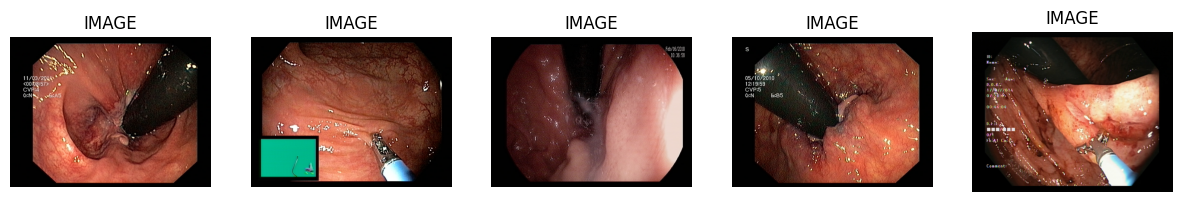

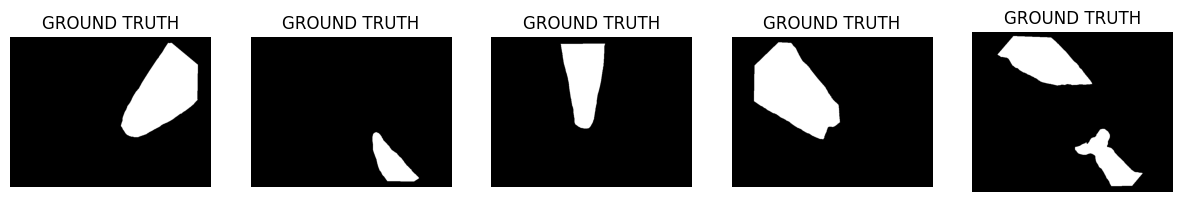

In [ ]:
# Load file names and create a DataFrame with absolute paths
image_files = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir)])
mask_files = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir)])
df = pd.DataFrame({'Image File': image_files, 'Mask File': mask_files})
sample = df.sample(n=5, random_state=42)

# Define functions to display images and masks
def generate_sample_images(sample):
    imgs = sample['Image File']

    _, ax = plt.subplots(1, 5, figsize=(15, 3))
    ax = ax.flatten()

    for i, image_path in enumerate(imgs):
        print(f"Loading image: {image_path}")

        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Could not load image at path {image_path}")
            ax[i].set_title("IMAGE NOT FOUND")
            ax[i].imshow(np.zeros((64, 64, 3), dtype=np.uint8))
            ax[i].axis('off')
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax[i].imshow(image)
        ax[i].set_title("IMAGE")
        ax[i].axis('off')

def generate_sample_masks(sample):
    masks = sample['Mask File']

    _, ax = plt.subplots(1, 5, figsize=(15, 3))
    ax = ax.flatten()

    for i, mask_path in enumerate(masks):
        print(f"Loading mask: {mask_path}")

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Warning: Could not load mask at path {mask_path}")
            ax[i].set_title("MASK NOT FOUND")
            ax[i].imshow(np.zeros((64, 64), dtype=np.uint8), cmap='gray')
            ax[i].axis('off')
            continue

        ax[i].imshow(mask, cmap='gray')
        ax[i].set_title("GROUND TRUTH")
        ax[i].axis('off')

# Generate and display sample images and masks
generate_sample_images(sample)
generate_sample_masks(sample)


## **1.2) Load train and test file lists :**

---



In [ ]:
with open('/content/train.txt', 'r') as f:
    train_files = f.read().splitlines()
with open('/content/test.txt', 'r') as f:
    test_files = f.read().splitlines()

print(f"Number of training files: {len(train_files)}")
print(f"Number of testing files: {len(test_files)}")
print(f"...........................................")
print(f"Example of testing files: {train_files[:5]}")
print(f"Example of testing files: {test_files[:5]}")

Number of training files: 472
Number of testing files: 118
...........................................
Example of testing files: ['ckcvw5yhd000m3b5yutirmiad', 'ckcvwpanj001b3b5ysxixpcxy', 'ckcuhbkeo000z3b5yq7v1sm0o', 'ckd0afl7u000a3b5y3crqjxla', 'ckcxb6cne000x3b5ynaznq58f']
Example of testing files: ['ckd4ipizn000d3b5yk2vrbyyz', 'ckcxct8oj000k3b5y9iwia72h', 'ckd4ig3d700043b5y0p70afjj', 'ckd03in4g001d3b5yngyc734r', 'ckcx9nmko001u3b5yopeccdvo']


## **1.3) Define image and mask transformations :**

---



In [ ]:
image_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.BICUBIC),  # Resize to smaller resolution # Use BICUBIC or NEAREST
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5,0.5])
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),  # Resize to smaller resolution
    transforms.ToTensor() # Converts the masks from [0, 255] to [0, 1] by dividing by 255 and converting to a PyTorch tensor.
])

Unique values in the transformed mask: [0. 1.]


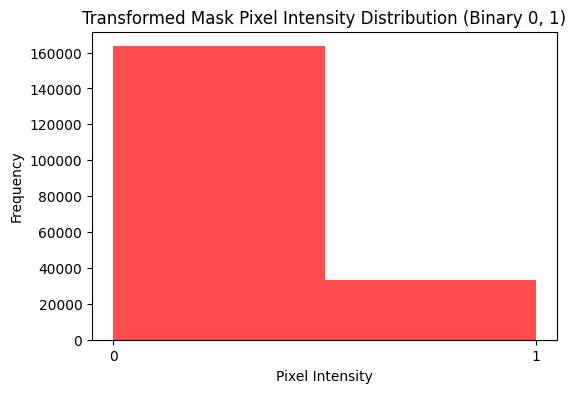

In [ ]:
# Load and transform a sample mask
mask_path = os.path.join(masks_dir, masks_list[0])
mask = Image.open(mask_path)
transformed_mask = mask_transform(mask)

# Convert to NumPy array and check unique values
mask_values = transformed_mask.numpy().flatten()
unique_values = np.unique(mask_values)
print("Unique values in the transformed mask:", unique_values)
plt.figure(figsize=(6, 4))
plt.hist(mask_values, bins=2, color='red', alpha=0.7)
plt.title("Transformed Mask Pixel Intensity Distribution (Binary 0, 1)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.xticks([0, 1])
plt.show()

## **1.4) Custom the data :**

---



The KvasirDataset class is a custom dataset for loading images and masks used in segmentation tasks. It loads images (RGB) and corresponding masks (grayscale) from specified directories, resizes them to a target size (default 256x256), and applies optional transformations. The images are read using OpenCV, converted to PIL format for compatibility with PyTorch, and returned as pairs for training.

In [ ]:
class KvasirDataset(Dataset):
    def __init__(self, file_list, img_dir, mask_dir, image_transform=None, mask_transform=None, target_size=(256, 256)):
        self.file_list = file_list
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform  # Use image_transform for images
        self.mask_transform = mask_transform  # Use mask_transform for masks
        self.target_size = target_size

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.img_dir, img_name + '.jpg')
        mask_path = os.path.join(self.mask_dir, img_name + '.png')

        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            raise ValueError(f"Error loading image or mask for {img_name}")

        image = cv2.resize(image, self.target_size, interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)


        # Convert the image from BGR (OpenCV format) to RGB and from NumPy array to PIL Image
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        mask = Image.fromarray(mask)

        # Apply the image transformation
        if self.image_transform:
            image = self.image_transform(image)

        # Apply the mask transformation
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

##  **1.5) Build training and testing datasets - Create DataLoaders for training and testing :**

In [ ]:
# Create training and testing datasets
train_dataset = KvasirDataset(train_files, images_dir, masks_dir, image_transform=image_transform, mask_transform=mask_transform)
test_dataset = KvasirDataset(test_files, images_dir, masks_dir, image_transform=image_transform, mask_transform=mask_transform)

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4, drop_last=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### ▶**Images and masks aftter added in train and test loader iteration:**

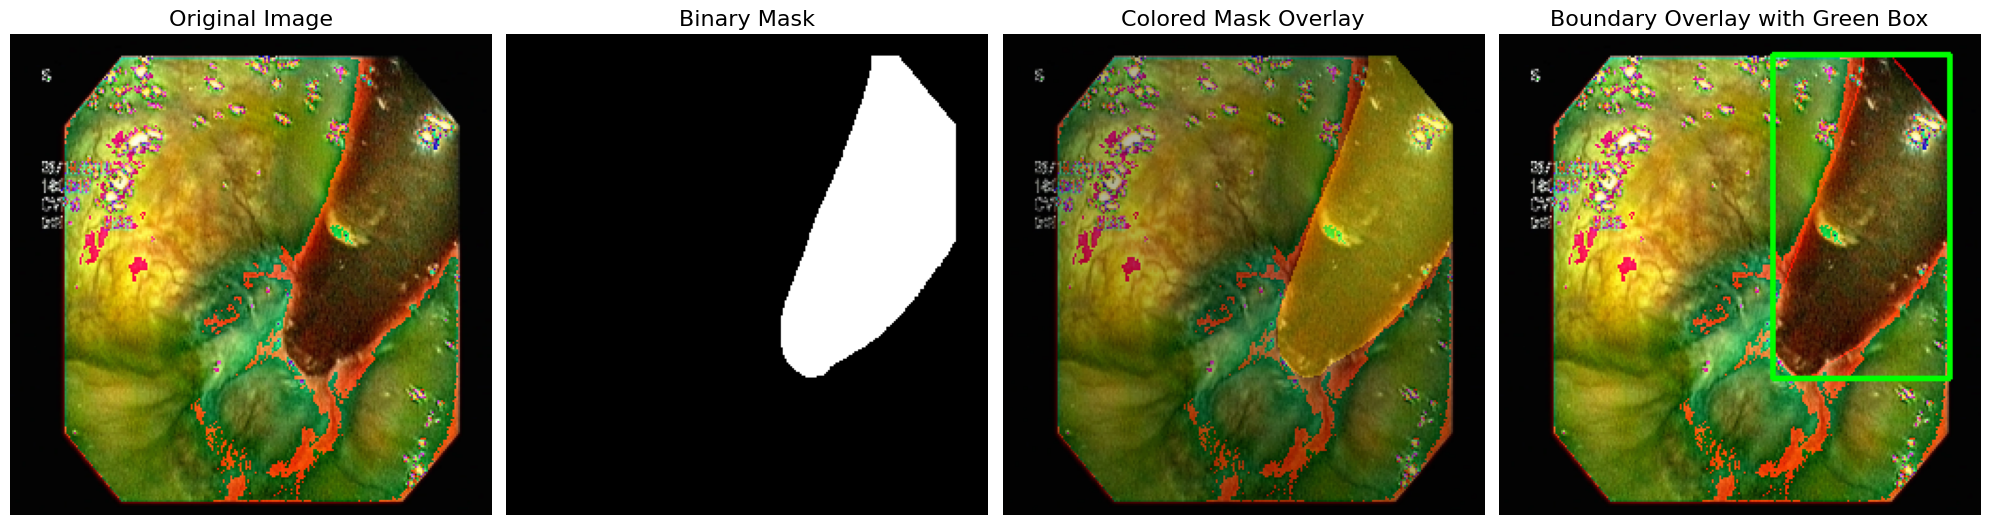

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch

for images, masks in test_loader:
    sample_image = images[0].permute(1, 2, 0).numpy()  # Convert to [H, W, C] format
    sample_image = (sample_image * 255).astype(np.uint8)
    sample_mask = masks[0].squeeze().numpy().astype(np.uint8)  # Convert mask to [H, W]
    break

plt.figure(figsize=(20, 10))

# 1. Original Image
plt.subplot(1, 4, 1)
plt.imshow(sample_image)
plt.title("Original Image", fontsize=16)
plt.axis("off")

# 2. Binary Mask
plt.subplot(1, 4, 2)
plt.imshow(sample_mask, cmap='gray')
plt.title("Binary Mask", fontsize=16)
plt.axis("off")

# 3. Colored Mask Overlay
colored_mask = np.zeros_like(sample_image)
colored_mask[sample_mask == 1] = [255, 255, 0]  # Yellow color
overlay = cv2.addWeighted(sample_image, 0.7, colored_mask, 0.3, 0)
plt.subplot(1, 4, 3)
plt.imshow(overlay)
plt.title("Colored Mask Overlay", fontsize=16)
plt.axis("off")

# 4. Boundary Overlay with Green Box
edges = cv2.Canny(sample_mask * 255, 0, 1)
edges_colored = np.stack([edges, np.zeros_like(edges), np.zeros_like(edges)], axis=2)
image_with_boundary = cv2.addWeighted(sample_image, 1, edges_colored, 0.7, 0)

# Find the bounding box around the boundary
x, y, w, h = cv2.boundingRect(edges)
cv2.rectangle(image_with_boundary, (x, y), (x + w, y + h), (0, 255, 0), 2)
plt.subplot(1, 4, 4)
plt.imshow(image_with_boundary)
plt.title("Boundary Overlay with Green Box", fontsize=16)
plt.axis("off")

plt.tight_layout()
plt.show()


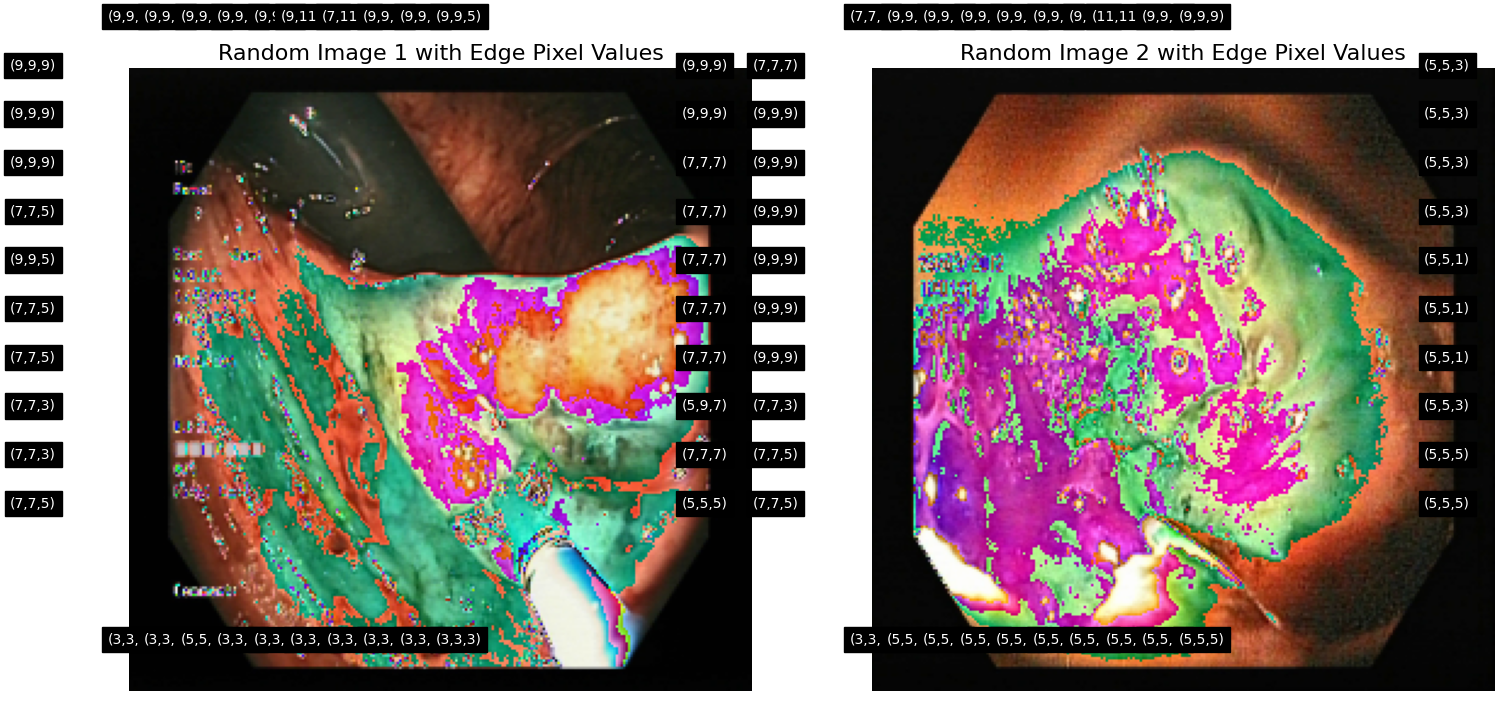

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

# Fetch one batch from the test loader
for images, masks in test_loader:
    random_indices = random.sample(range(images.shape[0]), 2)  # Randomly select 2 indices
    sample_images = [images[idx] for idx in random_indices]
    break

# Plot the 2 images
fig, axes = plt.subplots(1, 2, figsize=(15, 10))  # Adjust layout for 2 images

for i, sample_image in enumerate(sample_images):
    # Convert the sample image from a tensor to a NumPy array
    sample_image_np = sample_image.permute(1, 2, 0).numpy()  # Convert to [H, W, C] format
    sample_image_np = (sample_image_np * 255).astype(np.uint8)  # Scale to [0, 255]

    ax = axes[i]
    ax.imshow(sample_image_np)
    ax.set_title(f"Random Image {i+1} with Edge Pixel Values", fontsize=16)  # Larger title font

    # Show pixel values on the edges
    num_pixels = 10

    # Top edge
    top_edge_values = sample_image_np[0, :num_pixels]  # First row, first few pixels
    for j, (r, g, b) in enumerate(top_edge_values):
        ax.text(j * 15, -20, f"({r},{g},{b})", color='white', fontsize=10, ha='center', backgroundcolor='black')  # Increased fontsize

    # Bottom edge
    bottom_edge_values = sample_image_np[-1, :num_pixels]  # Last row, first few pixels
    for j, (r, g, b) in enumerate(bottom_edge_values):
        ax.text(j * 15, sample_image_np.shape[0] - 20, f"({r},{g},{b})", color='white', fontsize=10, ha='center', backgroundcolor='black')  # Increased fontsize

    # Left edge
    left_edge_values = sample_image_np[:num_pixels, 0]  # First column, first few pixels
    for j, (r, g, b) in enumerate(left_edge_values):
        ax.text(-40, j * 20, f"({r},{g},{b})", color='white', fontsize=10, ha='center', backgroundcolor='black')  # Increased fontsize

    # Right edge
    right_edge_values = sample_image_np[:num_pixels, -1]  # Last column, first few pixels
    for j, (r, g, b) in enumerate(right_edge_values):
        ax.text(sample_image_np.shape[1] - 20, j * 20, f"({r},{g},{b})", color='white', fontsize=10, ha='center', backgroundcolor='black')  # Increased fontsize

    ax.axis("off")

plt.tight_layout()
plt.show()


▶ **Verify by printing a sample bath size**

The images and masks are resized to 256x256 before and after transformations, with images having 3 channels (RGB) and masks having 1 channel (grayscale). The batch size is 8, and both images and masks have 4-dimensional tensors: **[batch_size, channels, height, width]**

In [ ]:
# Fetch a random batch from the DataLoader
for images, masks in train_loader:

    # before transformation
    print(f"Resized image size (before transformation): {images.shape}")
    print(f"Resized mask size (before transformation): {masks.shape}")

    # after transformation
    print(f"Image size after transformation: {images.size()}")
    print(f"Mask size after transformation: {masks.size()}")

    break
print('................................................................................')
images, masks = next(iter(train_loader))
print(f"Train batch - Images: {images.shape}, Masks: {masks.shape}")  #  gives the size of each dimension in a tuple form - 8: Batch size (likely 8 images processed at once) - 3: Number of channels (for RGB images - 256x256: Image resolution.
imafes, masks = next(iter(test_loader))
print(f"Train batch = Images: {images.shape}, Masks: {masks.shape}")
print('.................................................................................')
print(f"Image dimension: {np.array(images).ndim}") # the number of dimensions - batch size, channels, height, and widt
print(f"Maak dimension: {np.array(masks).ndim}")

Resized image size (before transformation): torch.Size([8, 3, 256, 256])
Resized mask size (before transformation): torch.Size([8, 1, 256, 256])
Image size after transformation: torch.Size([8, 3, 256, 256])
Mask size after transformation: torch.Size([8, 1, 256, 256])
................................................................................
Train batch - Images: torch.Size([8, 3, 256, 256]), Masks: torch.Size([8, 1, 256, 256])
Train batch = Images: torch.Size([8, 3, 256, 256]), Masks: torch.Size([8, 1, 256, 256])
.................................................................................
Image dimension: 4
Maak dimension: 4


▶ **Print the number of batches in each loader**

In [ ]:
print(f"Number of training batches: {len(train_loader)}") # 472 / 8
print(f"Number of testing batches: {len(test_loader)}") # 118 / 8

Number of training batches: 59
Number of testing batches: 15


▶ **Check if masks in the DataLoader are binary**

In [ ]:
# Check if masks in the DataLoader are binary
for images, masks in train_loader:
    unique_values = torch.unique(masks)
    print("Unique values in a batch of masks:", unique_values)
    if not torch.all((unique_values == 0) | (unique_values == 1)):
        print("Warning: Mask contains values other than 0 and 1.")
    else:
        print("Masks are binary.")
    break  # Check only the first batch


Unique values in a batch of masks: tensor([0., 1.])
Masks are binary.




---


# **2. Define the model architecture**


---



#### **Create segmentation model use U-net**

U-Net is a well-known deep learning architecture for medical picture segmentation.


**1. Encoder (Contracting Path):** Uses convolutional layers with ReLU and max-pooling to extract features and downsample the image. Dropout is applied for regularization.


**2. Bottleneck:** Captures abstract features at the lowest resolution before upsampling.


**3. Decoder (Expanding Path):** Uses transposed convolutions to upsample the feature maps. Skip connections link corresponding encoder and decoder layers to preserve spatial details.


**4. Output:** A 1x1 convolution followed by a sigmoid activation for pixel-wise binary classification.


This implementation is designed for binary segmentation tasks, where each pixel is labeled as part of the object or background.

In [ ]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder part (contracting path)
        self.enc1 = self.conv_block(3, 64, p=0.3)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = self.conv_block(64, 128, p=0.3)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = self.conv_block(128, 256, p=0.3)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = self.conv_block(256, 512, p=0.3)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck (bottom of the U)
        self.bottleneck = self.conv_block(512, 1024, p=0.3)

        # Decoder part (expanding path)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512, p=0.3)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256, p=0.3)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128, p=0.3)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64, p=0.3)

        # Final output layer
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels, p=0.3):
        """Convolutional block with dropout."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(), # Relu activation function
            nn.Dropout(p)
        )

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)
        p1 = self.pool1(x1)

        x2 = self.enc2(p1)
        p2 = self.pool2(x2)

        x3 = self.enc3(p2)
        p3 = self.pool3(x3)

        x4 = self.enc4(p3)
        p4 = self.pool4(x4)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder with skip connections
        u4 = self.upconv4(b)
        d4 = torch.cat([u4, x4], dim=1)  # Skip connection
        d4 = self.dec4(d4)

        u3 = self.upconv3(d4)
        d3 = torch.cat([u3, x3], dim=1)  # Skip connection
        d3 = self.dec3(d3)

        u2 = self.upconv2(d3)
        d2 = torch.cat([u2, x2], dim=1)  # Skip connection
        d2 = self.dec2(d2)

        u1 = self.upconv1(d2)
        d1 = torch.cat([u1, x1], dim=1)  # Skip connection
        d1 = self.dec1(d1)

        # Final output layer
        out = self.final(d1)
        return torch.sigmoid(out)  # Sigmoid for binary segmentation must remains the same




---


# **3. Define the loss function and optimizer**

---



▶  **Reinitialize the model and optimizer**


> **Optimizer:** Adam


> **Loss Function:** Binary Cross-Entropy  (BCELoss)


> **Learning rate scheduler:** 0.001

The model and optimizer are reinitialized using the U-Net architecture, with  (BCELoss) as the loss function and Adam optimizer. A learning rate scheduler (CosineAnnealingLR) is set to decay the learning rate every 10 epochs




In [ ]:
# Reinitialize the model and optimizer
import torch.optim.lr_scheduler as lr_scheduler
from torchsummary import summary

model = UNet()
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
images, masks = images.to(device), masks.to(device)
print(device)
summary(model, input_size=(3, 256, 256)) # input size

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
           Dropout-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
              ReLU-5         [-1, 64, 256, 256]               0
           Dropout-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
              ReLU-9        [-1, 128, 128, 128]               0
          Dropout-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
             ReLU-12        [-1, 128, 128, 128]               0
          Dropout-13        [-1, 128, 128, 128]               0
        MaxPool2d-14          [-1,



---


# **4. Train the model**

---






#### **Training Process:**

*   **Evaluation Metrics:**
  *   Metrics such as **pixel-level accuracy, DSC, IoU, precision, recall, F1-score, and BCE Loss** were used to evaluate the model’s performance. The training was limited to 30 epochs, and metrics were averaged to compare the outcomes across three resolutions..
  *   Additionally, **Accuracy, Precision, Recall, and F1-score** are used to provide further insights into the model's performance by measuring overall correctness (accuracy) and performance for specific classes (precision, recall, and F1).

*   **Training Configuration:**

  *  **Batch Size:** Start with a batch size of 8, suitable for this dataset size.
  *   **Epochs:** Train for 30 epochs

▶ **Calculate Metrics Function accuracy, precision, recall, F1-score, IOU and DSC**

In [ ]:
def calculate_metrics_function(true_mask, predicted_masks, smooth=1e-6):
    true_mask = true_mask.to(predicted_masks.device)
    true_masks_flat = true_mask.view(-1).cpu().numpy()
    predicted_masks_flat = predicted_masks.view(-1).cpu().numpy()

    # True Positives, False Positives, False Negatives
    TruePositive = np.sum((true_masks_flat == 1) & (predicted_masks_flat == 1))
    FalsePositive = np.sum((true_masks_flat == 0) & (predicted_masks_flat == 1))
    FalseNegative = np.sum((true_masks_flat == 1) & (predicted_masks_flat == 0))

    # Accuracy
    total_pixels = true_masks_flat.size
    accuracy = (TruePositive + (total_pixels - TruePositive - FalsePositive - FalseNegative)) / total_pixels

    # Precision, Recall, F1-score, DSC
    precision_score = TruePositive / (TruePositive + FalsePositive) if (TruePositive + FalsePositive) > 0 else 0
    recall_score = TruePositive / (TruePositive + FalseNegative) if (TruePositive + FalseNegative) > 0 else 0
    f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score) if (precision_score + recall_score) > 0 else 0
    dcs_score = (2 * TruePositive + smooth) / (2 * TruePositive + FalsePositive + FalseNegative + smooth)

    # IoU (Intersection over Union)
    union = TruePositive + FalsePositive + FalseNegative
    iou = (TruePositive + smooth) / (union + smooth)

    return accuracy * 100, precision_score, recall_score, f1_score, dcs_score, iou

▶ **Train function**

In [ ]:
def train_model(model, train_loader, criterion, optimizer, device):
  model.train()
  train_loss = 0.0
  correct_pixels = 0
  total_pixels = 0
  total_dsc = 0
  total_iou = 0

  for images, masks in train_loader:
      images, masks = images.to(device), masks.to(device)
      optimizer.zero_grad()

      outputs = model(images)
      loss = criterion(outputs, masks)
      train_loss += loss.item()

      predicted_masks = (torch.sigmoid(outputs) > 0.5).float()

      # calculate training accuracy
      predicted_masks = (outputs > 0.5).float()
      correct_pixels += (predicted_masks == masks).float().sum().item()
      total_pixels += masks.numel()

      # Calculate Dice Coe
      _,_,_,_,dsc, iou = calculate_metrics_function(masks, predicted_masks)
      total_dsc += dsc
      total_iou += iou

      loss.backward()
      optimizer.step()

  avg_train_loss = train_loss / len(train_loader)
  train_accuracy = 100 * correct_pixels / total_pixels
  avg_dsc = total_dsc / len(train_loader)
  avg_iou = total_iou / len(train_loader)

  return avg_train_loss, train_accuracy, avg_dsc, avg_iou



---


# **5. Test the model**

---






In [ ]:
def test_model(model, test_loader, criterion, device):
  model.eval()
  test_loss = 0
  all_true_masks = []
  all_predicted_masks = []

  with torch.no_grad():
    for images, masks in test_loader:

      images, masks = images.to(device), masks.to(device)

      # Forward pass function
      outputs = model(images)
      loss = criterion(outputs, masks)
      test_loss += loss.item()

      # Save true and predicted masks
      all_true_masks.append(masks)
      all_predicted_masks.append((outputs > 0.5).float())

  # Conclude all the results across batches
  all_true_masks = torch.cat(all_true_masks)
  all_predicted_masks = torch.cat(all_predicted_masks)

  # Calculate metrics
  accuracy, precision_score, recall_score, f1_score, dcs_score, iou = calculate_metrics_function(all_true_masks, all_predicted_masks)
  avg_test_loss = test_loss / len(test_loader)

  return avg_test_loss, accuracy, precision_score, recall_score, f1_score, dcs_score, iou

## ▶ **Print metrics for the current epoch : 30 with early stooping in patience of 10**

In [ ]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
images, masks = images.to(device), masks.to(device)

# Early stopping parameters
patience = 5
best_test_dsc = 0
epochs_no_improve = 0
epochs_number = 30

# Initialize W&B
wandb.init(project="final_master_template", entity="kandidat18-kristiania-university-college", config={
    "optimizer": "ADAM",
    "epochs": epochs_number,
})

# Lists to store metrics' results
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
train_dsc_values = []
test_dsc_values = []
train_iou_values = []
test_iou_values = []

epochs_number = 30

# Training loop
for epoch in range(epochs_number):
    print(f"Epoch [{epoch + 1}/{epochs_number}]")

    # Training step
    train_loss, train_accuracy, train_dsc, train_iou = train_model(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_dsc_values.append(train_dsc)
    train_iou_values.append(train_iou)

    # Testing step
    test_loss, test_accuracy, precision_score, recall_score, f1_score, test_dsc, test_iou = test_model(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    test_dsc_values.append(test_dsc)
    test_iou_values.append(test_iou)

    # Log both training and testing metrics to WandB
    wandb.log({
        "Epoch": epoch + 1,
        "Train Loss": train_loss,
        "Train Accuracy": train_accuracy,
        "Train DSC": train_dsc,
        "Train IoU": train_iou,
        "Test Loss": test_loss,
        "Test Accuracy": test_accuracy,
        "Test Precision": precision_score,
        "Test Recall": recall_score,
        "Test F1-Score": f1_score,
        "Test DSC": test_dsc,
        "Test IoU": test_iou
    })

    # Print metrics
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Train DSC: {train_dsc:.4f}, Train IoU: {train_iou:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, "
          f"Test Precision: {precision_score:.4f}, Test Recall: {recall_score:.4f}, "
          f"Test F1-Score: {f1_score:.4f}, Test DSC: {test_dsc:.4f}, Test IoU: {test_iou:.4f}\n")

    # Step the scheduler based on test loss
    scheduler.step(test_loss)

    # Early stopping check on Test DSC
    if test_dsc > best_test_dsc:
        best_test_dsc = test_dsc
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # Check if early stopping condition is met
    if epochs_no_improve >= patience:
        print("Early stopping break!")
        break

# Finish the WandB run
wandb.finish()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kandidat18 (kandidat18-kristiania-university-college). Use `wandb login --relogin` to force relogin


Epoch [1/30]


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.2864, Train Accuracy: 87.90%, Train DSC: 0.0438, Train IoU: 0.0242
Test Loss: 0.2187, Test Accuracy: 92.22%, Test Precision: 0.6622, Test Recall: 0.3370, Test F1-Score: 0.4466, Test DSC: 0.4466, Test IoU: 0.2875

Epoch [2/30]


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Loss: 0.2021, Train Accuracy: 92.04%, Train DSC: 0.4323, Train IoU: 0.2837
Test Loss: 0.1569, Test Accuracy: 95.07%, Test Precision: 0.8013, Test Recall: 0.6270, Test F1-Score: 0.7035, Test DSC: 0.7035, Test IoU: 0.5426

Epoch [3/30]
Train Loss: 0.1784, Train Accuracy: 93.41%, Train DSC: 0.5897, Train IoU: 0.4282
Test Loss: 0.1569, Test Accuracy: 94.90%, Test Precision: 0.7034, Test Recall: 0.7829, Test F1-Score: 0.7410, Test DSC: 0.7410, Test IoU: 0.5886

Epoch [4/30]
Train Loss: 0.1660, Train Accuracy: 93.71%, Train DSC: 0.6217, Train IoU: 0.4631
Test Loss: 0.1660, Test Accuracy: 93.87%, Test Precision: 0.6261, Test Recall: 0.8491, Test F1-Score: 0.7208, Test DSC: 0.7208, Test IoU: 0.5634

Epoch [5/30]
Train Loss: 0.1617, Train Accuracy: 93.48%, Train DSC: 0.6109, Train IoU: 0.4506
Test Loss: 0.1185, Test Accuracy: 95.24%, Test Precision: 0.7747, Test Recall: 0.6900, Test F1-Score: 0.7299, Test DSC: 0.7299, Test IoU: 0.5747

Epoch [6/30]
Train Loss: 0.1645, Train Accuracy: 93.6

## 🌱 **Metrics summary :**


| **Metric**           | **Values** |
|-----------------------|---------------|
| **Epoch**             | 8      
| **Test Accuracy**     | 94.84756      |
| **Test DSC**          | 0.72887       |
| **Test F1-Score**     | 0.72887       |
| **Test IoU**          | 0.57340       |
| **Test Loss**         | 0.12741       |
| **Test Precision**    | 0.71532       |
| **Test Recall**       | 0.74293       |
| **Train Accuracy**    | 93.96435      |
| **Train DSC**         | 0.65342       |
| **Train IoU**         | 0.49673       |
| **Train Loss**        | 0.15250       |



## ▶ **Plot the result into Wandb Report**


---

To keep the code more intuitive and easier to follow, we integrated the results with the W&B (Weights & Biases) library, which automatically generates interactive metric plots. You can view the interactive plots by following this link: : [Click to view an interactive visualization](https://wandb.ai/kandidat18-kristiania-university-college/final_master_template/reports/Jupyter-Notebook-1-Master-U-Net-Workflow--VmlldzoxMDI1NDQ0Ng?accessToken=lw1jnfpk4hi6wyhelz1h549wo8igtda566878h7s0067fnuym3r6v08315n85uw2)



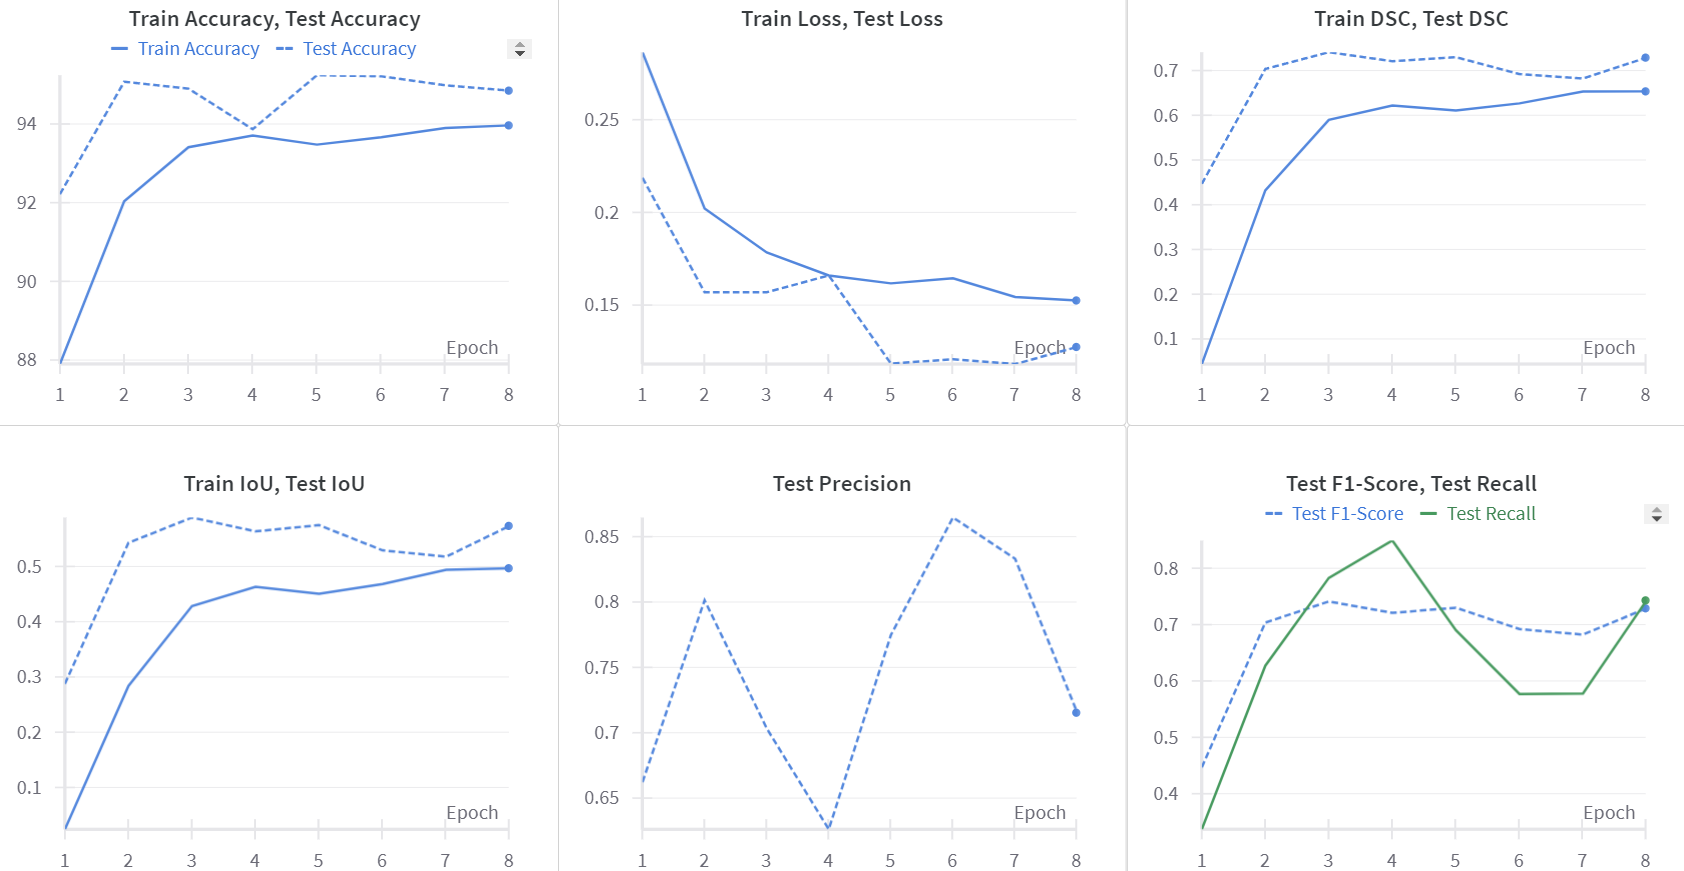



---


# **6. Making the prediction and experiment**

---



### ▶ **Compare Original Image and Ground Truth Mask with Predicted Mask**

The function evaluates model performance by displaying predictions for segmentation tasks. It collects images, ground truth masks, and predicted masks from the test set, calculates Intersection over Union (IoU) for each prediction, and visualizes the results. The display_predictions function plots the original image, ground truth mask, and predicted mask along with the IoU score. Additionally, IoU for each image is printed. Based on multiple experiments, a threshold of 0.5 was found to be the most suitable for this experiment.

▶  **Function to display original, ground truth, and predicted masks with their IoUs (Intersection over Union) with 20 samples**

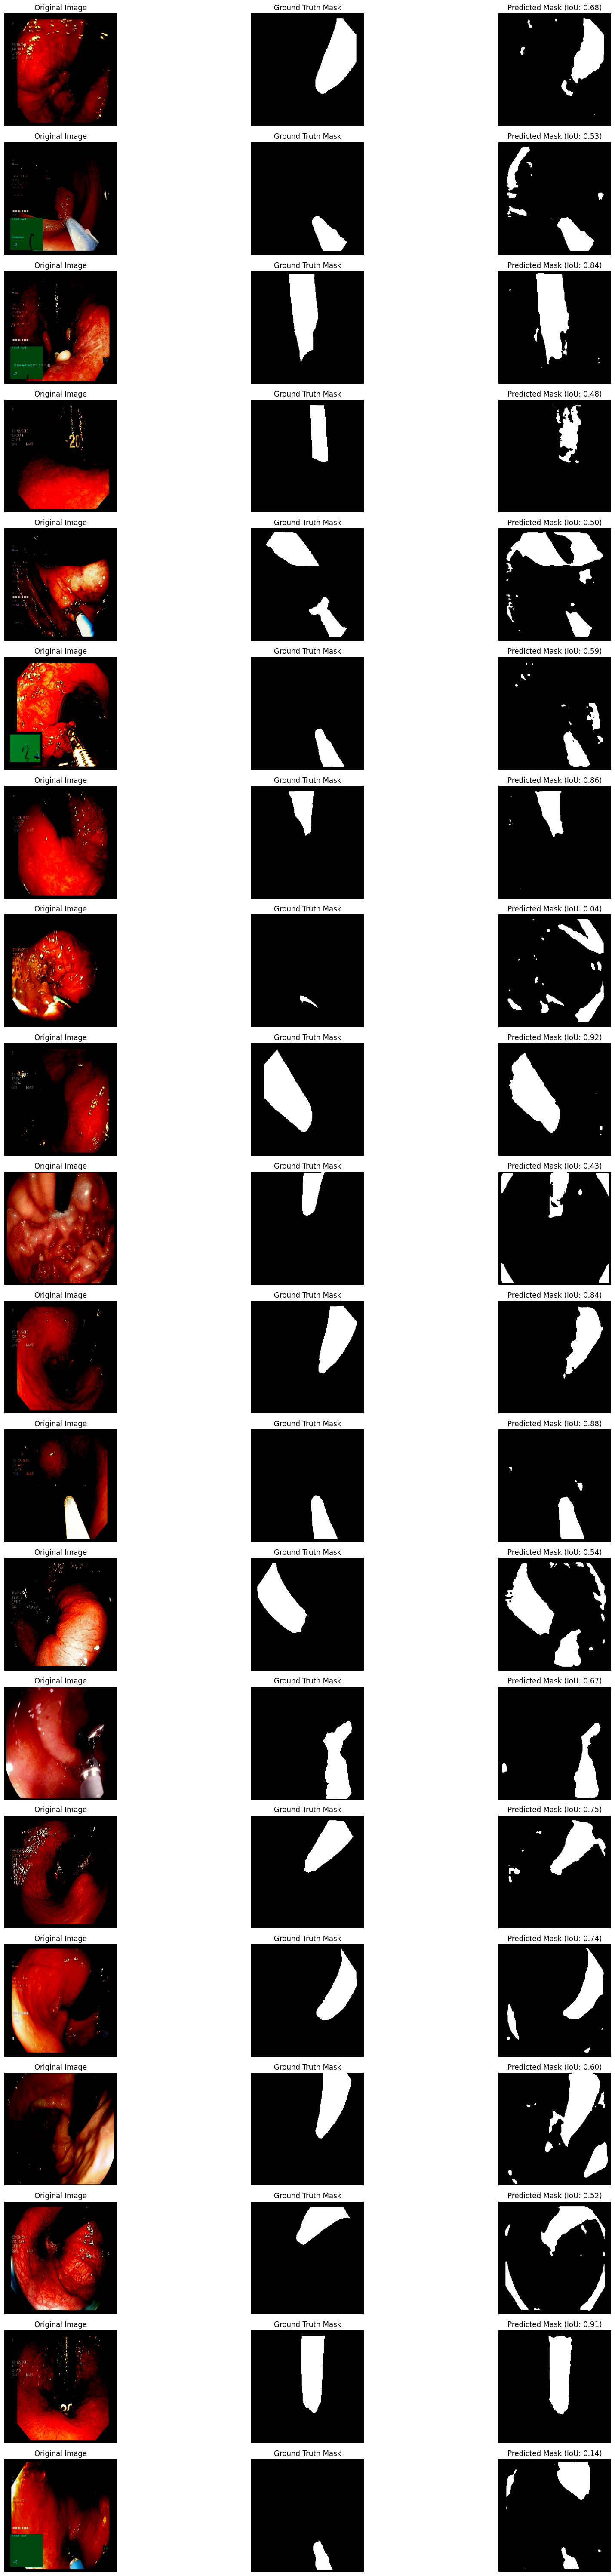

Image 1 IoU: 0.68
Image 2 IoU: 0.53
Image 3 IoU: 0.84
Image 4 IoU: 0.48
Image 5 IoU: 0.50
Image 6 IoU: 0.59
Image 7 IoU: 0.86
Image 8 IoU: 0.04
Image 9 IoU: 0.92
Image 10 IoU: 0.43
Image 11 IoU: 0.84
Image 12 IoU: 0.88
Image 13 IoU: 0.54
Image 14 IoU: 0.67
Image 15 IoU: 0.75
Image 16 IoU: 0.74
Image 17 IoU: 0.60
Image 18 IoU: 0.52
Image 19 IoU: 0.91
Image 20 IoU: 0.14


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def display_predictions(images, true_masks, predicted_masks, ious, num_images=20):
    plt.figure(figsize=(20, num_images * 3))
    for i in range(num_images):
        for j, (img, title) in enumerate(zip(
            [images[i].cpu().numpy().transpose(1, 2, 0), true_masks[i].cpu().numpy().squeeze(), predicted_masks[i].cpu().numpy().squeeze()],
            ["Original Image", "Ground Truth Mask", f"Predicted Mask (IoU: {ious[i]:.2f})"]
        )):
            plt.subplot(num_images, 3, i * 3 + j + 1)
            plt.imshow(img, cmap='gray' if j else None)
            plt.title(title)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

def calculate_iou_per_image(true_masks, predicted_masks, threshold=0.5):
    return [(pred_mask := (predicted_masks[i] > threshold).float(), true_mask := true_masks[i].float(),
             (intersection := (pred_mask * true_mask).sum()),
             union := pred_mask.sum() + true_mask.sum() - intersection,
             0 if union == 0 else intersection / union)[-1].item()
            for i in range(true_masks.size(0))]

# Collect images from multiple batches
collected_images, collected_masks, collected_pred_masks, collected_ious = [], [], [], []
for images, masks in test_loader:
    images, masks = images.to(device), masks.to(device)
    with torch.no_grad():
        predicted_masks = (model(images) > 0.49).float()
    collected_images.extend(images.cpu())
    collected_masks.extend(masks.cpu())
    collected_pred_masks.extend(predicted_masks.cpu())
    collected_ious.extend(calculate_iou_per_image(masks, predicted_masks))
    if len(collected_images) >= 20:
        break

collected_images, collected_masks, collected_pred_masks = map(lambda x: torch.stack(x)[:20], [collected_images, collected_masks, collected_pred_masks])
collected_ious = collected_ious[:20]

# Show predictions and IoUs
display_predictions(collected_images, collected_masks, collected_pred_masks, collected_ious)
for idx, iou in enumerate(collected_ious):
    print(f"Image {idx + 1} IoU: {iou:.2f}")


▶  **Save the model state dictionary**

In [ ]:
torch.save(model.state_dict(), 'unet_model.pth')